In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Where Are Real Galaxies?

Real galaxies would ideally be distributed evenly throughout the hypercube. If they are clustered in one pocket, our cube is over too large a range of real parameters and we're wasting cube-points teaching the emulator about the photometry of parameter values that no real galaxy has.

Happily, it looks like the galaxies are fairly well spread. We can also 

In [13]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner


from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils

In [10]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3.parquet'
catalog = load_catalog(catalog_loc)

In [3]:
os.chdir('/home/mike/repos/agnfinder')
grid_loc = 'data/photometry_simulation_100000.hdf5'

In [4]:
assert os.path.isfile(grid_loc)
with h5py.File(grid_loc, 'r') as f:
    param_names = f['samples']['theta'].attrs['columns']  # stored as "attribute" metadata
    norm_theta = f['samples']['normalised_theta'][...]
    theta = f['samples']['theta'][...]
    simulated_y = f['samples']['simulated_y'][...]
    wavelengths = f['samples']['wavelengths'][...]

In [42]:
output_dim = 7
n_photometry_bands = 12
n_galaxies = 5000

In [39]:
best_thetas = np.zeros((n_galaxies, output_dim))
best_norm_theta = np.zeros((n_galaxies, output_dim))
for n in range(n_galaxies):  # could probably do in one go if this is slow
    _, photometry, _ = load_photometry.load_maggies_from_galaxy(catalog.sample().squeeze(), reliable=True)
    error = np.sum((photometry - simulated_y) ** 2, axis=1)
    best_params_index = np.argmin(error) # equivalent to an MLE in discrete space
    best_thetas[n] = theta[best_params_index]
    best_norm_theta[n] = norm_theta[best_params_index]


In [54]:
from sedpy import observate

In [70]:
from agnfinder.prospector.load_photometry import Filter

In [71]:
valid_filters = [Filter(bandpass_file='u_sloan', mag_col='mag_auto_sdss_u_dr12', error_col='magerr_auto_sdss_u_dr12'), Filter(bandpass_file='g_sloan', mag_col='mag_auto_sdss_g_dr12', error_col='magerr_auto_sdss_g_dr12'), Filter(bandpass_file='r_sloan', mag_col='mag_auto_sdss_r_dr12', error_col='magerr_auto_sdss_r_dr12'), Filter(bandpass_file='i_sloan', mag_col='mag_auto_sdss_i_dr12', error_col='magerr_auto_sdss_i_dr12'), Filter(bandpass_file='z_sloan', mag_col='mag_auto_sdss_z_dr12', error_col='magerr_auto_sdss_z_dr12'), Filter(bandpass_file='VISTA_H', mag_col='mag_auto_viking_h_dr2', error_col='magerr_auto_viking_h_dr2'), Filter(bandpass_file='VISTA_J', mag_col='mag_auto_viking_j_dr2', error_col='magerr_auto_viking_j_dr2'), Filter(bandpass_file='VISTA_Ks', mag_col='mag_auto_viking_k_dr2', error_col='magerr_auto_viking_k_dr2'), Filter(bandpass_file='VISTA_Y', mag_col='mag_auto_viking_y_dr2', error_col='magerr_auto_viking_y_dr2'), Filter(bandpass_file='VISTA_Z', mag_col='mag_auto_viking_z_dr2', error_col='magerr_auto_viking_z_dr2'), Filter(bandpass_file='wise_w1', mag_col='mag_auto_AllWISE_W1', error_col='magerr_auto_AllWISE_W1'), Filter(bandpass_file='wise_w2', mag_col='mag_auto_AllWISE_W2', error_col='magerr_auto_AllWISE_W2')]

In [72]:
# sped up version that assumes data is good and gets filters just once
def load_maggies_from_galaxy_fast(galaxy): # run the first
    mags = np.array(galaxy[[f.mag_col for f in valid_filters]].values).astype(float)
    maggies = 10**(-0.4*mags)
    return maggies
 

NameError: name 'valid_filters' is not defined

In [60]:
%%timeit
load_photometry.load_maggies_from_galaxy(catalog.sample().squeeze(), reliable=True)

107 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
load_maggies_from_galaxy_fast(catalog.sample().squeeze())

2.57 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
from tqdm.auto import tqdm  # notebook friendly

In [90]:
n_galaxies = 20000  # for quasars, some may possibly be repeats - not a big deal

In [106]:
spectro_class = '1'  # 1=galaxy, 2=agn, 3=qso, see main.py
if spectro_class is None:
    selected_catalog = catalog
else:
    selected_catalog = catalog.query(f'hclass == {spectro_class}')

In [107]:
all_photometry = np.zeros((n_galaxies, n_photometry_bands))
for n in tqdm(range(n_galaxies)):  # could probably do in one go if this is slow
    photometry = load_maggies_from_galaxy_fast(selected_catalog.sample().squeeze())
    all_photometry[n, :] = photometry

In [108]:
assert len(all_photometry) == n_galaxies

In [109]:
best_thetas = np.zeros((n_galaxies, output_dim))
best_norm_theta = np.zeros((n_galaxies, output_dim))
for n, photometry in tqdm(enumerate(all_photometry)):
    error = np.sum((photometry - simulated_y) ** 2, axis=1)
    best_params_index = np.argmin(error) # equivalent to an MLE in discrete space
    best_thetas[n] = theta[best_params_index]
    best_norm_theta[n] = norm_theta[best_params_index]

In [110]:
best_thetas

array([[1.60724625e+11, 2.00112742e-01, 1.03281917e+01, ...,
        8.95511815e-06, 3.98983231e-01, 1.18056714e-05],
       [2.29636982e+10, 7.53382891e-02, 3.01489361e+00, ...,
        1.11510527e-03, 3.44240931e-01, 1.15907668e-04],
       [6.78277756e+10, 5.83679159e-02, 1.08183457e+00, ...,
        2.56015074e-06, 1.99009310e-01, 5.33413429e-07],
       ...,
       [7.90992392e+10, 1.46377054e+00, 5.36649245e+00, ...,
        3.47336338e-04, 1.49761604e-01, 2.48443718e-04],
       [1.74241345e+11, 6.18207612e-01, 1.07153095e+01, ...,
        2.97567180e-07, 1.44238140e-01, 1.51616204e-04],
       [7.90992392e+10, 1.46377054e+00, 5.36649245e+00, ...,
        3.47336338e-04, 1.49761604e-01, 2.48443718e-04]])

<Figure size 432x288 with 0 Axes>

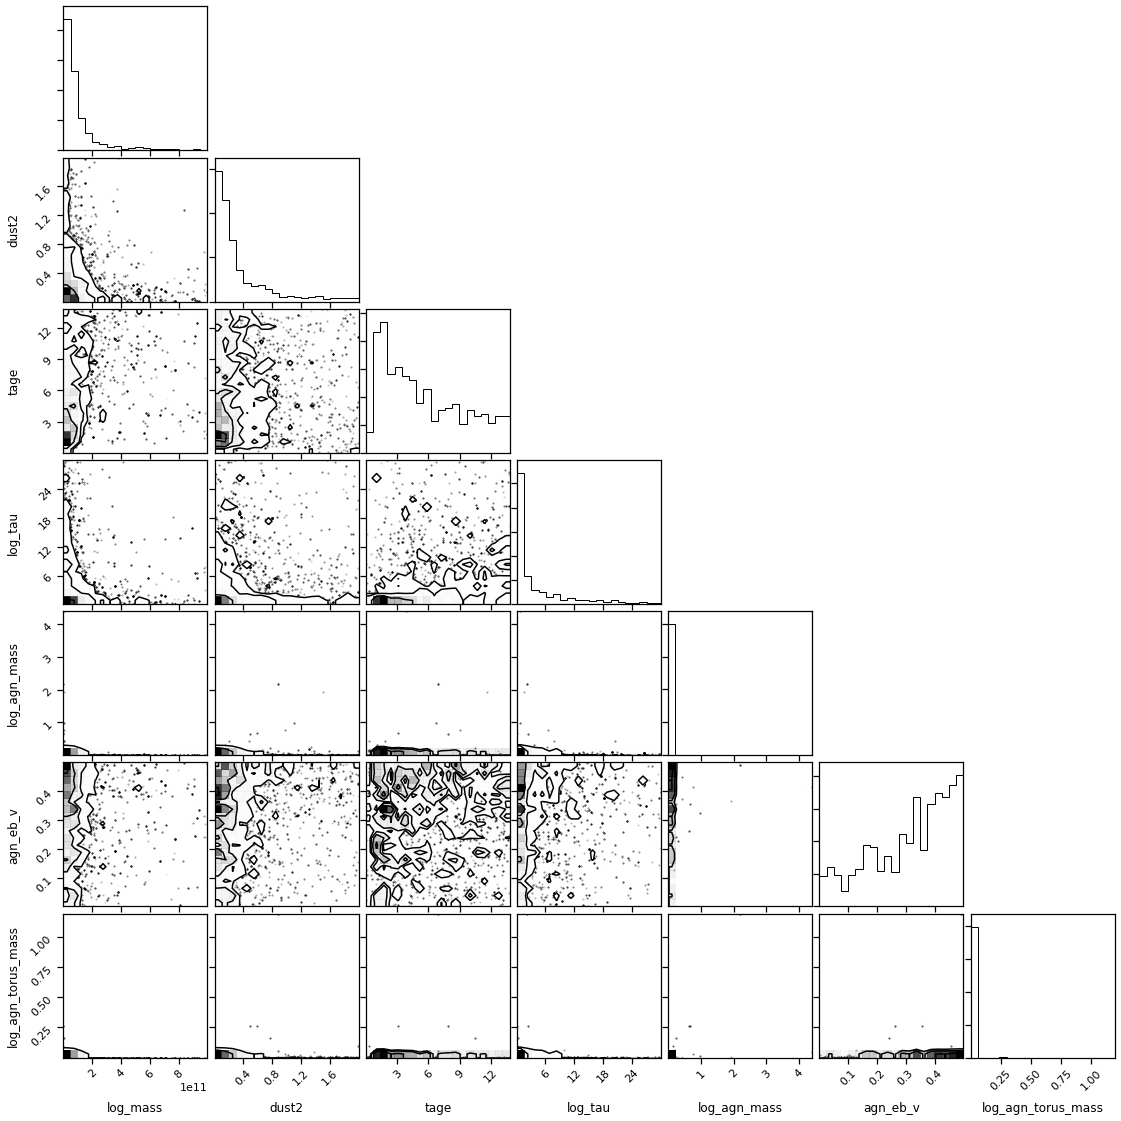

In [111]:
best_thetas_logged = best_thetas.copy()
for param_n, param in enumerate(param_names):
    if 'log' in param:
        best_thetas_logged[:, param_n] = np.log10(best_thetas[:, param_n])

plt.figure()
_ = corner.corner(best_thetas, labels=param_names)
plt.savefig(f'best_theta_{spectro_class}_{n_galaxies}.pdf')

<Figure size 432x288 with 0 Axes>

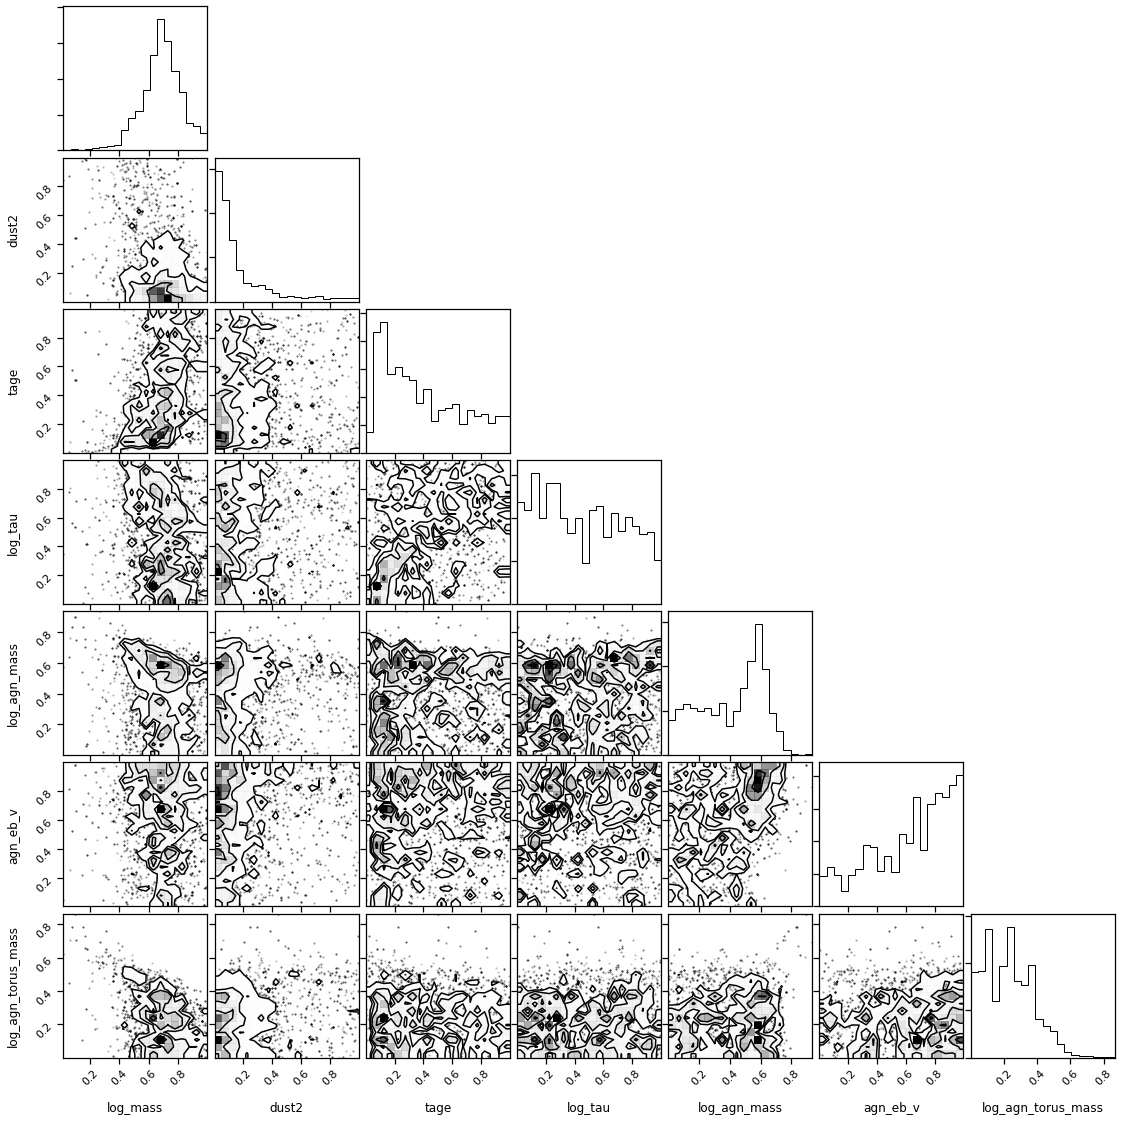

In [112]:

plt.figure()
_ = corner.corner(best_norm_theta, labels=param_names)
plt.savefig(f'best_norm_theta_{spectro_class}_{n_galaxies}.pdf')